In [1]:
import io
import requests

import pandas as pd
import polars as pl
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('talk')

In [2]:
pdf = pd.read_parquet('../data/raw/ftransfer_elasticc_2023-02-15_946675/classId=121')

In [3]:
def extract_history(history_list: list, field: str) -> list:
    """Extract the historical measurements contained in the alerts
    for the parameter `field`.

    Parameters
    ----------
    history_list: list of dict
        List of dictionary from alert[history].
    field: str
        The field name for which you want to extract the data. It must be
        a key of elements of history_list
    
    Returns
    ----------
    measurement: list
        List of all the `field` measurements contained in the alerts.
    """
    if history_list is None:
        return []
    try:
        measurement = [obs[field] for obs in history_list]
    except KeyError:
        print('{} not in history data'.format(field))
        measurement = []

    return measurement

def extract_field(alert: dict, category: str, field: str, key: str) -> np.array:
    """ Concatenate current and historical observation data for a given field.
    
    Parameters
    ----------
    alert: dict
        Dictionnary containing alert data
    category: str
        prvDiaSources or prvDiaForcedSources
    field: str
        Name of the field to extract.
    
    Returns
    ----------
    data: np.array
        List containing previous measurements and current measurement at the
        end. If `field` is not in the category, data will be
        [alert['diaSource'][field]].
    """
    data = np.concatenate(
        [
            [alert[key][field]],
            extract_history(alert[category], field)
        ]
    )
    return data

In [4]:
pdf['target'] = 121

In [5]:
pdf["diaObject"][0]

{'decl': -49.696072651146864,
 'diaObjectId': 146402526,
 'hostgal2_dec': -999.0,
 'hostgal2_ellipticity': -9999.0,
 'hostgal2_mag_Y': 999.0,
 'hostgal2_mag_g': 999.0,
 'hostgal2_mag_i': 999.0,
 'hostgal2_mag_r': 999.0,
 'hostgal2_mag_u': 999.0,
 'hostgal2_mag_z': 999.0,
 'hostgal2_magerr_Y': 999.0,
 'hostgal2_magerr_g': 999.0,
 'hostgal2_magerr_i': 999.0,
 'hostgal2_magerr_r': 999.0,
 'hostgal2_magerr_u': 999.0,
 'hostgal2_magerr_z': 999.0,
 'hostgal2_ra': -999.0,
 'hostgal2_snsep': -9.0,
 'hostgal2_sqradius': -9999.0,
 'hostgal2_zphot': -999.0,
 'hostgal2_zphot_err': -999.0,
 'hostgal2_zphot_p50': None,
 'hostgal2_zphot_q000': -9.0,
 'hostgal2_zphot_q010': -9.0,
 'hostgal2_zphot_q020': -9.0,
 'hostgal2_zphot_q030': -9.0,
 'hostgal2_zphot_q040': -9.0,
 'hostgal2_zphot_q050': -9.0,
 'hostgal2_zphot_q060': -9.0,
 'hostgal2_zphot_q070': -9.0,
 'hostgal2_zphot_q080': -9.0,
 'hostgal2_zphot_q090': -9.0,
 'hostgal2_zphot_q100': -9.0,
 'hostgal2_zspec': -999.0,
 'hostgal2_zspec_err': -999.0,

In [6]:
print(pdf.columns)

Index(['alertId', 'diaSource', 'prvDiaSources', 'prvDiaForcedSources',
       'prvDiaNondetectionLimits', 'diaObject', 'cutoutDifference',
       'cutoutTemplate', 'brokerIngestTimestamp', 'timestamp',
       'rf_snia_vs_nonia', 'snn_snia_vs_nonia', 'snn_broad_class',
       'snn_broad_max_prob', 'cats_broad_class', 'cats_broad_max_prob',
       'cats_fine_class', 'cats_fine_max_prob', 'rf_agn_vs_nonagn',
       't2_broad_class', 't2_broad_max_prob', 'fink_broker_version',
       'fink_science_version', 'publisher', 'SNID', 'LIBID',
       'SIM_SEARCHEFF_MASK', 'GENTYPE', 'SIM_TEMPLATE_INDEX', 'ZCMB', 'ZHELIO',
       'ZCMB_SMEAR', 'RA', 'DEC', 'MWEBV', 'GALNMATCH', 'GALID', 'GALZPHOT',
       'GALZPHOTERR', 'GALSNSEP', 'GALSNDDLR', 'RV', 'AV', 'MU', 'LENSDMU',
       'PEAKMJD', 'MJD_DETECT_FIRST', 'MJD_DETECT_LAST', 'DTSEASON_PEAK',
       'PEAKMAG_u', 'PEAKMAG_g', 'PEAKMAG_r', 'PEAKMAG_i', 'PEAKMAG_z',
       'PEAKMAG_Y', 'SNRMAX', 'SNRMAX2', 'SNRMAX3', 'NOBS', 'NOBS_SATURATE',
     

In [7]:
pdf["NOBS"][0]

149

In [8]:
pdf['cpsFlux'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFlux', 'diaSource'), axis=1)
pdf['cpsFluxErr'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'psFluxErr', 'diaSource'), axis=1)
pdf['cfilterName'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'filterName', 'diaSource'), axis=1)
pdf['cmidPointTai'] = pdf[['diaSource', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'midPointTai', 'diaSource'), axis=1)

pdf['cZ'] = pdf[['diaObject', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'z_final', 'diaObject'), axis=1)
pdf['cZerr'] = pdf[['diaObject', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'z_final_err', 'diaObject'), axis=1)
pdf['cMwebv'] = pdf[['diaObject', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'mwebv', 'diaObject'), axis=1)
pdf['cRa'] = pdf[['diaObject', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'ra', 'diaObject'), axis=1)
pdf['cDecl'] = pdf[['diaObject', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'decl', 'diaObject'), axis=1)
pdf['cHostgal_ra'] = pdf[['diaObject', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'hostgal_ra', 'diaObject'), axis=1)
pdf['cHostgal_dec'] = pdf[['diaObject', 'prvDiaForcedSources']]\
    .apply(lambda x: extract_field(x, 'prvDiaForcedSources', 'hostgal_dec', 'diaObject'), axis=1)

cols = ['alertId', 'target', 'cmidPointTai', 'cpsFlux', 'cpsFluxErr', 'cfilterName', 'cZ', \
        'cZerr', 'cMwebv', 'cRa', 'cDecl', 'cHostgal_ra', 'cHostgal_dec', \
        'SNID', 'NOBS']
sub = pdf[cols]
sub

z_final not in history data
z_final not in history data
z_final not in history data
z_final not in history data
z_final not in history data
z_final_err not in history data
z_final_err not in history data
z_final_err not in history data
z_final_err not in history data
z_final_err not in history data
mwebv not in history data
mwebv not in history data
mwebv not in history data
mwebv not in history data
mwebv not in history data
ra not in history data
ra not in history data
ra not in history data
ra not in history data
ra not in history data
decl not in history data
decl not in history data
decl not in history data
decl not in history data
decl not in history data
hostgal_ra not in history data
hostgal_ra not in history data
hostgal_ra not in history data
hostgal_ra not in history data
hostgal_ra not in history data
hostgal_dec not in history data
hostgal_dec not in history data
hostgal_dec not in history data
hostgal_dec not in history data
hostgal_dec not in history data


,alertId,target,cmidPointTai,cpsFlux,cpsFluxErr,cfilterName,cZ,cZerr,cMwebv,cRa,cDecl,cHostgal_ra,cHostgal_dec,SNID,NOBS
0,292805052048,121,[60607.0736],[517.75732421875],[221.70233154296875],[i],[0.16344062983989716],[0.16808000206947327],[0.009014381095767021],[0.9676724344437256],[-49.696072651146864],[0.9677252769470215],[-49.69614791870117],146402526,149
1,236811186028,121,[60320.1313],[1169.298583984375],[196.1234130859375],[i],[0.1338547170162201],[0.1252799928188324],[0.00950966402888298],[69.52126616511217],[-50.38369680355572],[69.52117156982422],[-50.38372802734375],118405593,127
2,181886744009,121,[60549.1873],[1041.65673828125],[273.07745361328125],[r],[0.23332324624061584],[0.22684000432491302],[0.006137879565358162],[2.553227017279791],[-43.31437494725598],[2.5532901287078857],[-43.3144645690918],90943372,237
3,221478330013,121,[60609.3722],[2575.27392578125],[692.6956787109375],[r],[0.050953783094882965],[0.0010000000474974513],[0.014673247002065182],[57.33047750559256],[-53.56728248804294],[57.33053207397461],[-53.567298889160156],110739165,115
4,250750812072,121,[60466.004],[1167.426513671875],[206.24415588378906],[i],[0.1325898915529251],[0.0010000000474974513],[0.08095170557498932],[188.22928460733328],[-40.88442885410509],[188.22918701171875],[-40.88450622558594],125375406,157
5,164227482030,121,"[60340.3594, 60314.2508, 60314.2756, 60314.286...","[4735.275390625, -231.21820068359375, -552.134...","[644.0177001953125, 310.8291015625, 462.648345...","[z, i, z, z, Y, r, i, r, r, r, r, r, i, i, Y, ...",[0.11739850789308548],[0.13095000386238098],[0.05223875492811203],[157.65726394121165],[-22.807671218881783],[157.65725708007812],[-22.807472229003906],82113741,163
6,164227482031,121,"[60340.3716, 60314.2508, 60314.2756, 60314.286...","[4800.42529296875, -231.21820068359375, -552.1...","[693.317138671875, 310.8291015625, 462.6483459...","[z, i, z, z, Y, r, i, r, r, r, r, r, i, i, Y, ...",[0.11739850789308548],[0.13095000386238098],[0.05223875492811203],[157.65726394121165],[-22.807671218881783],[157.65725708007812],[-22.807472229003906],82113741,163
7,164227482029,121,"[60340.3479, 60314.2508, 60314.2756, 60314.286...","[4983.572265625, -231.21820068359375, -552.134...","[417.4020080566406, 310.8291015625, 462.648345...","[i, i, z, z, Y, r, i, r, r, r, r, r, i, i, Y, ...",[0.11739850789308548],[0.13095000386238098],[0.05223875492811203],[157.65726394121165],[-22.807671218881783],[157.65725708007812],[-22.807472229003906],82113741,163
8,38666284032,121,[60593.2405],[791.9251098632812],[153.12400817871094],[g],[0.16801081597805023],[0.1820099949836731],[0.012775149196386337],[24.38803778053321],[-45.10943347471609],[24.38807487487793],[-45.10942840576172],19333142,236
9,38666284033,121,[60593.2654],[1764.031982421875],[156.42236328125],[r],[0.16801081597805023],[0.1820099949836731],[0.012775149196386337],[24.38803778053321],[-45.10943347471609],[24.38807487487793],[-45.10942840576172],19333142,236


In [9]:
sub.shape

(40, 15)

In [10]:
def f(x):
    y = len(list(set(x))) > 1
    #sample function
    return y 

df = sub["cfilterName"].apply(f)
sub = sub[df].reset_index()

In [11]:
def f(x):
    y = len(x) > 1
    #sample function
    return y 

df = sub["cmidPointTai"].apply(f)
sub = sub[df].reset_index(drop=True)

In [12]:
sub

,index,alertId,target,cmidPointTai,cpsFlux,cpsFluxErr,cfilterName,cZ,cZerr,cMwebv,cRa,cDecl,cHostgal_ra,cHostgal_dec,SNID,NOBS
0,5,164227482030,121,"[60340.3594, 60314.2508, 60314.2756, 60314.286...","[4735.275390625, -231.21820068359375, -552.134...","[644.0177001953125, 310.8291015625, 462.648345...","[z, i, z, z, Y, r, i, r, r, r, r, r, i, i, Y, ...",[0.11739850789308548],[0.13095000386238098],[0.05223875492811203],[157.65726394121165],[-22.807671218881783],[157.65725708007812],[-22.807472229003906],82113741,163
1,6,164227482031,121,"[60340.3716, 60314.2508, 60314.2756, 60314.286...","[4800.42529296875, -231.21820068359375, -552.1...","[693.317138671875, 310.8291015625, 462.6483459...","[z, i, z, z, Y, r, i, r, r, r, r, r, i, i, Y, ...",[0.11739850789308548],[0.13095000386238098],[0.05223875492811203],[157.65726394121165],[-22.807671218881783],[157.65725708007812],[-22.807472229003906],82113741,163
2,7,164227482029,121,"[60340.3479, 60314.2508, 60314.2756, 60314.286...","[4983.572265625, -231.21820068359375, -552.134...","[417.4020080566406, 310.8291015625, 462.648345...","[i, i, z, z, Y, r, i, r, r, r, r, r, i, i, Y, ...",[0.11739850789308548],[0.13095000386238098],[0.05223875492811203],[157.65726394121165],[-22.807671218881783],[157.65725708007812],[-22.807472229003906],82113741,163
3,18,21885874059,121,"[60402.2838, 60373.1789, 60373.2036, 60374.358...","[2180.092041015625, 21.62727165222168, -357.32...","[384.5772705078125, 132.51869201660156, 165.11...","[z, g, r, i, i, u, u, g, g, u, u, g, u, r, u, ...",[0.039679743349552155],[0.0010000000474974513],[0.05719093605875969],[182.52191475033388],[-31.762338815591793],[182.52183532714844],[-31.76241111755371],10942937,156
4,25,22178354056,121,"[60505.9886, 60485.2627, 60485.2858, 60487.110...","[1518.2388916015625, -132.09169006347656, 3814...","[575.2952880859375, 1908.2532958984375, 1704.3...","[i, Y, Y, z, i, r, r, i, i, g, r, r, i, u, r, ...",[0.4057801365852356],[0.4137299954891205],[0.11362776160240173],[261.71389743791696],[-56.57013324218278],[261.7138671875],[-56.570159912109375],11089177,173


In [23]:
df = sub.explode(column=["cmidPointTai", "cpsFlux", "cpsFluxErr", "cfilterName"]).sort_values(by=["index", "cfilterName"])

df = df.explode(column=["cZ", "cZerr", "cMwebv", "cRa", "cDecl", "cHostgal_ra", "cHostgal_dec"])

df = df.rename(columns={"alertId": "object_id", "SNID": "uid","cmidPointTai": "mjd", "cpsFlux": "flux", "cpsFluxErr": "flux_error", "cfilterName": "filter", "cZ": "z", "cZerr": "z_error", "cMwebv": "mwebv", "cRa": "ra", "cDecl": "dec", "cHostgal_ra": "hostgal_ra", "cHostgal_dec": "hostgal_dec", "NOBS":"nobs"})

df

,index,object_id,target,mjd,flux,flux_error,filter,z,z_error,mwebv,ra,dec,hostgal_ra,hostgal_dec,uid,nobs
0,5,164227482030,121,60314.3082,-909.906738,875.011841,Y,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60327.3531,-1183.322876,872.459351,Y,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60327.3627,504.018555,972.680969,Y,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60335.3411,-1140.665161,1279.748901,Y,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60335.3513,340.209076,1157.631958,Y,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,25,22178354056,121,60502.9846,115.243492,288.178101,r,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,121,60493.0226,846.669983,492.181671,u,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,121,60487.1102,-117.665466,596.135376,z,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,121,60503.9988,978.907166,444.619537,z,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173


In [25]:
len(df["object_id"].unique())

5

In [26]:
from astronet.preprocess import generate_gp_all_objects, remap_filters, generate_gp_single_event
from astronet.constants import *

In [27]:
df = remap_filters(df, filter_map=ELASTICC_FILTER_MAP)
df

,index,object_id,target,mjd,flux,flux_error,filter,z,z_error,mwebv,ra,dec,hostgal_ra,hostgal_dec,uid,nobs
0,5,164227482030,121,60314.3082,-909.906738,875.011841,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60327.3531,-1183.322876,872.459351,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60327.3627,504.018555,972.680969,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60335.3411,-1140.665161,1279.748901,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,121,60335.3513,340.209076,1157.631958,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,25,22178354056,121,60502.9846,115.243492,288.178101,lsstr,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,121,60493.0226,846.669983,492.181671,lsstu,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,121,60487.1102,-117.665466,596.135376,lsstz,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,121,60503.9988,978.907166,444.619537,lsstz,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173


In [28]:
df.shape[1]

16

In [29]:
ddf = df.drop(columns=["index"])

In [30]:
alert_list = list(np.unique(ddf["object_id"]))
len(alert_list)

5

In [31]:
ddf

,object_id,target,mjd,flux,flux_error,filter,z,z_error,mwebv,ra,dec,hostgal_ra,hostgal_dec,uid,nobs
0,164227482030,121,60314.3082,-909.906738,875.011841,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,164227482030,121,60327.3531,-1183.322876,872.459351,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,164227482030,121,60327.3627,504.018555,972.680969,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,164227482030,121,60335.3411,-1140.665161,1279.748901,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,164227482030,121,60335.3513,340.209076,1157.631958,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,22178354056,121,60502.9846,115.243492,288.178101,lsstr,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,22178354056,121,60493.0226,846.669983,492.181671,lsstu,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,22178354056,121,60487.1102,-117.665466,596.135376,lsstz,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,22178354056,121,60503.9988,978.907166,444.619537,lsstz,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173


In [32]:
# %%timeit -n1 -r1
generated_gp_dataset = generate_gp_all_objects(alert_list, ddf)

COMPLETED OBJECT ID:21885874059
COMPLETED OBJECT ID:22178354056
COMPLETED OBJECT ID:164227482029
COMPLETED OBJECT ID:164227482030
COMPLETED OBJECT ID:164227482031


In [33]:
generated_gp_dataset

filter,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id
0,60373.1789,5.784332,-475.880856,-331.217566,183.172202,-452.582491,-487.316182,21885874059.0
1,60373.472889,29.039092,-373.989486,-236.311752,192.509753,-375.881144,-397.447268,21885874059.0
2,60373.766878,90.217354,-191.903027,-81.482767,206.287882,-239.051407,-233.595306,21885874059.0
3,60374.060867,177.077381,-2.713941,76.595215,245.358628,-84.797444,-54.222094,21885874059.0
4,60374.354856,261.693686,151.08947,206.850586,295.681688,46.878851,94.262018,21885874059.0
...,...,...,...,...,...,...,...,...
495,60339.316214,2835.673254,3642.483405,3332.631673,2413.031939,3612.309305,3723.997605,164227482031.0
496,60339.580061,3137.336016,4068.375929,3716.162384,2651.120675,3973.153907,4134.155076,164227482031.0
497,60339.843907,3375.646675,4408.169679,4022.774796,2838.76808,4229.360635,4444.785711,164227482031.0
498,60340.107754,3533.499128,4634.299654,4225.663606,2964.748626,4374.779797,4637.031035,164227482031.0


In [36]:
ddf = df.drop(columns=["mjd", "filter", "flux", "flux_error", "target"])

In [37]:
ddf

,index,object_id,z,z_error,mwebv,ra,dec,hostgal_ra,hostgal_dec,uid,nobs
0,5,164227482030,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
0,5,164227482030,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
...,...,...,...,...,...,...,...,...,...,...,...
4,25,22178354056,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173
4,25,22178354056,0.40578,0.41373,0.113628,261.713897,-56.570133,261.713867,-56.57016,11089177,173


In [38]:
df_with_xfeats = generated_gp_dataset.merge(ddf, on="object_id", how="inner")
df_with_xfeats

,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id,index,z,z_error,mwebv,ra,dec,hostgal_ra,hostgal_dec,uid,nobs
0,60373.1789,5.784332,-475.880856,-331.217566,183.172202,-452.582491,-487.316182,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
1,60373.1789,5.784332,-475.880856,-331.217566,183.172202,-452.582491,-487.316182,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
2,60373.1789,5.784332,-475.880856,-331.217566,183.172202,-452.582491,-487.316182,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
3,60373.1789,5.784332,-475.880856,-331.217566,183.172202,-452.582491,-487.316182,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
4,60373.1789,5.784332,-475.880856,-331.217566,183.172202,-452.582491,-487.316182,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12295,60340.3716,3599.130368,4709.121007,4299.669922,3022.115192,4399.895077,4686.239088,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
12296,60340.3716,3599.130368,4709.121007,4299.669922,3022.115192,4399.895077,4686.239088,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
12297,60340.3716,3599.130368,4709.121007,4299.669922,3022.115192,4399.895077,4686.239088,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
12298,60340.3716,3599.130368,4709.121007,4299.669922,3022.115192,4399.895077,4686.239088,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163


In [39]:
df_with_xfeats.drop_duplicates(keep='first', inplace=True, ignore_index=True)

In [40]:
df_with_xfeats

,mjd,lsstg,lssti,lsstr,lsstu,lssty,lsstz,object_id,index,z,z_error,mwebv,ra,dec,hostgal_ra,hostgal_dec,uid,nobs
0,60373.1789,5.784332,-475.880856,-331.217566,183.172202,-452.582491,-487.316182,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
1,60373.472889,29.039092,-373.989486,-236.311752,192.509753,-375.881144,-397.447268,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
2,60373.766878,90.217354,-191.903027,-81.482767,206.287882,-239.051407,-233.595306,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
3,60374.060867,177.077381,-2.713941,76.595215,245.358628,-84.797444,-54.222094,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
4,60374.354856,261.693686,151.08947,206.850586,295.681688,46.878851,94.262018,21885874059.0,18,0.03968,0.001,0.057191,182.521915,-31.762339,182.521835,-31.762411,10942937,156
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,60339.316214,2835.673254,3642.483405,3332.631673,2413.031939,3612.309305,3723.997605,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
496,60339.580061,3137.336016,4068.375929,3716.162384,2651.120675,3973.153907,4134.155076,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
497,60339.843907,3375.646675,4408.169679,4022.774796,2838.76808,4229.360635,4444.785711,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
498,60340.107754,3533.499128,4634.299654,4225.663606,2964.748626,4374.779797,4637.031035,164227482031.0,6,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163


In [41]:
len(generated_gp_dataset["object_id"].unique())

5

In [42]:
from astronet.viz.visualise_data import *
import random

In [46]:
data = df[df["object_id"] == random.choice(alert_list)]

In [47]:
data

,index,object_id,target,mjd,flux,flux_error,filter,z,z_error,mwebv,ra,dec,hostgal_ra,hostgal_dec,uid,nobs
1,6,164227482031,121,60314.3082,-909.906738,875.011841,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60327.3531,-1183.322876,872.459351,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60327.3627,504.018555,972.680969,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60335.3411,-1140.665161,1279.748901,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60335.3513,340.209076,1157.631958,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60339.3362,6172.255859,1754.083862,lssty,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60314.2508,-231.218201,310.829102,lssti,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60318.2694,358.595886,264.157166,lssti,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60324.2566,147.180511,222.996368,lssti,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163
1,6,164227482031,121,60324.2588,214.253799,232.221832,lssti,0.117399,0.13095,0.052239,157.657264,-22.807671,157.657257,-22.807472,82113741,163


In [48]:
len(data["filter"].unique())

4

In [55]:
data["object_id"].iloc[0]

164227482031

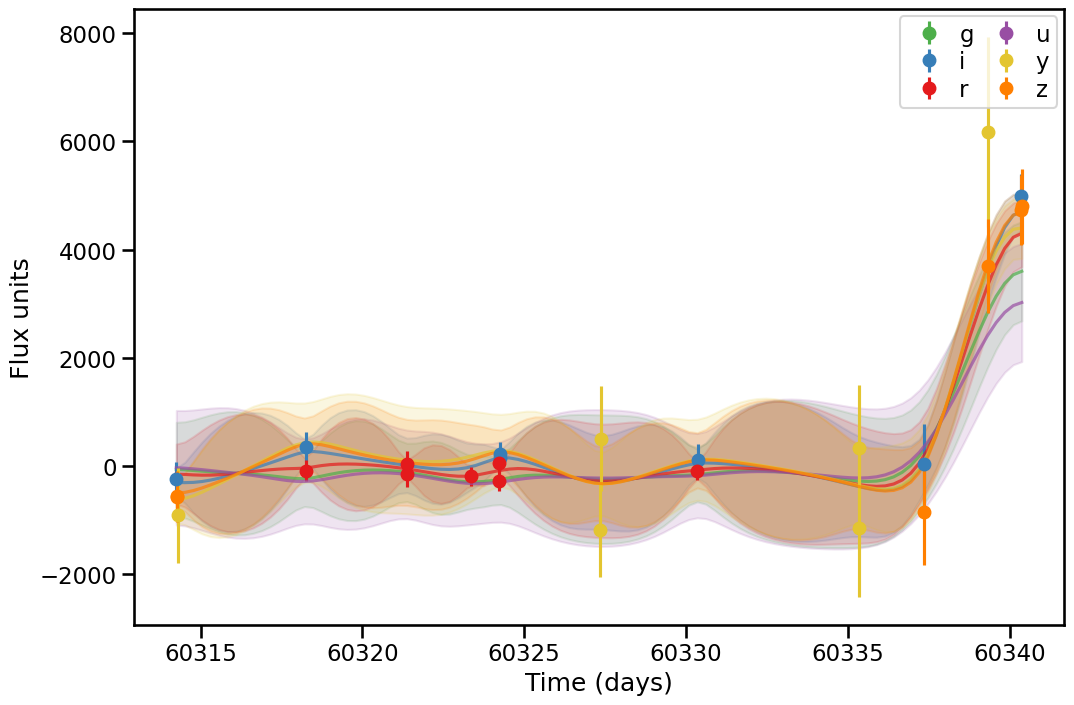

In [49]:
_obj_gps = generate_gp_single_event(data)
ax = plot_event_data_with_model(data, obj_model=_obj_gps, pb_colors=ELASTICC_PB_COLORS)

In [50]:
_obj_gps

,mjd,flux,flux_error,filter
0,60314.250800,-30.749138,1058.208865,lsstu
1,60314.514646,-38.943624,1065.519901,lsstu
2,60314.778493,-50.965963,1088.588994,lsstu
3,60315.042339,-65.703254,1120.278647,lsstu
4,60315.306186,-81.964924,1152.701541,lsstu
...,...,...,...,...
595,60339.316214,3612.309305,648.525894,lssty
596,60339.580061,3973.153907,612.500175,lssty
597,60339.843907,4229.360635,582.475693,lssty
598,60340.107754,4374.779797,556.411416,lssty


In [ ]:
_obj_gps["filter"].unique()

In [ ]:
# N = 3
# seed = np.random.seed(1)
# indices = np.random.randint(0, len(sub), N)

# for index in indices:
#     fig = plt.figure(figsize=(12, 6))
    
#     data = sub.iloc[index]
#     filters = np.unique(data['cfilterName'])
    
#     for filt in filters:
#         cond = data['cfilterName'] == filt
        
#         plt.errorbar(
#             data['cmidPointTai'][cond], 
#             data['cpsFlux'][cond], 
#             data['cpsFluxErr'][cond],
#             ls='',
#             marker='o',
#             label='{} band'.format(filt)
#         )
#     plt.title('ID {} -- class: {}'.format(data['alertId'], data['classId']))
#     plt.legend()
#     plt.show()